Epoch 1/25
67/67 [==============================] - 36s 455ms/step - loss: 0.0100
Epoch 2/25
67/67 [==============================] - 30s 452ms/step - loss: 0.0037
Epoch 3/25
67/67 [==============================] - 30s 448ms/step - loss: 0.0033
Epoch 4/25
67/67 [==============================] - 33s 490ms/step - loss: 0.0031
Epoch 5/25
67/67 [==============================] - 30s 456ms/step - loss: 0.0030
Epoch 6/25
67/67 [==============================] - 31s 468ms/step - loss: 0.0030
Epoch 7/25
67/67 [==============================] - 31s 462ms/step - loss: 0.0024
Epoch 8/25
67/67 [==============================] - 30s 446ms/step - loss: 0.0025
Epoch 9/25
67/67 [==============================] - 29s 435ms/step - loss: 0.0023
Epoch 10/25
67/67 [==============================] - 29s 432ms/step - loss: 0.0024
Epoch 11/25
67/67 [==============================] - 29s 432ms/step - loss: 0.0023
Epoch 12/25
67/67 [==============================] - 29s 432ms/step - loss: 0.0026
Epoch 13/25
6

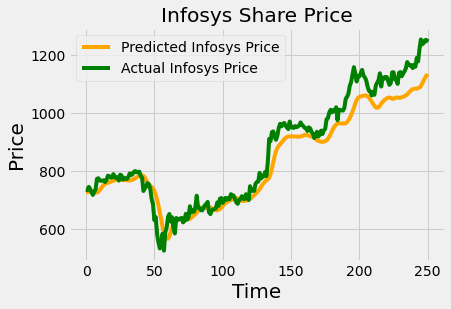

In [2]:
import investpy
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")


# Get DataFrame of required stock from investpy
data = investpy.get_stock_historical_data(stock     ='infy',
                                        country   ='india',
                                        from_date ='01/01/2010',
                                        to_date   ='31/12/2019',
                                        order     ='ascending')

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1,1))

prediction_days = 365

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#Build the model
model = Sequential()
model.add(LSTM(units = 50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=20, batch_size=32)

''' Test The Model Acurracy on Existing Data'''

# Load Test Data
test_start = '01/01/2020'
test_end = '31/12/2020'

test_data = investpy.get_stock_historical_data(stock     ='infy',
                                        country   ='india',
                                        from_date = test_start,
                                        to_date   = test_end,
                                        order     ='ascending')

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

#Make Predictions on Test Data

x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

#plot the Test Predictions

plt.plot(predicted_prices, color='orange', label='Predicted Infosys Price')
plt.plot(actual_prices, color='green', label='Actual Infosys Price')
plt.title('Infosys Share Price')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend()
plt.show()